In [1]:
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config import *
from Data.raw_data_loader import load_raw_crypto_csv
from Models.ou import build_spread, ou_signal_on_spread
from Backtest.metrics import build_summary_table, rolling_sharpe

plt.style.use("default")

In [2]:
df = load_raw_crypto_csv(DATA_PATH)

df = df.copy()
df = df.loc["2017-11-12":].copy()

btc = df["BTC-USD_close"].astype(float)
eth = df["ETH-USD_close"].astype(float)

# Drop remaining garbage / anomaly rows
mask = (btc > 0) & (eth > 0)
mask &= (btc.pct_change().abs() < 1.0)
mask &= (eth.pct_change().abs() < 1.0)
df = df.loc[mask].copy()

btc = df["BTC-USD_close"].astype(float)
eth = df["ETH-USD_close"].astype(float)

print("Rows:", len(df), "Start:", df.index.min(), "End:", df.index.max())


Rows: 3008 Start: 2017-11-13 00:00:00 End: 2026-02-09 00:00:00


In [3]:
def pair_portfolio_returns(df: pd.DataFrame, beta_window: int, position: pd.Series) -> pd.Series:
    """
    Convert spread position into portfolio returns:
      r_t = pos_{t-1} * ( r_eth - beta * r_btc )

    beta computed on log prices with rolling window.
    """
    log_b = np.log(df["BTC-USD_close"].astype(float))
    log_e = np.log(df["ETH-USD_close"].astype(float))

    minp = min(beta_window, max(30, beta_window // 3))
    cov = log_b.rolling(beta_window, min_periods=minp).cov(log_e)
    var = log_b.rolling(beta_window, min_periods=minp).var()
    beta = (cov / var).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    r_btc = df["BTC-USD_close"].astype(float).pct_change().fillna(0.0)
    r_eth = df["ETH-USD_close"].astype(float).pct_change().fillna(0.0)

    position = position.reindex(df.index).fillna(0.0)
    pnl = position.shift(1).fillna(0.0) * (r_eth - beta * r_btc)
    return pnl

In [4]:
def apply_turnover_cost(returns: pd.Series, position: pd.Series, fee_bps: float, slippage_bps: float) -> pd.Series:
    """
    Apply linear costs proportional to turnover:
      cost = turnover * (fee+slippage) in bps converted to decimal.
    """
    pos = position.reindex(returns.index).fillna(0.0)
    turnover = pos.diff().abs().fillna(0.0)

    cost_rate = (fee_bps + slippage_bps) / 1e4
    net = returns - turnover * cost_rate
    return net

In [5]:
def walk_forward_splits(index: pd.DatetimeIndex, train_days: int, test_days: int, step_days: int):
    """
    Yield (train_start, train_end, test_start, test_end) with expanding train.
    """
    start = index.min()
    end = index.max()

    train_start = start
    train_end = start + pd.Timedelta(days=train_days)

    while True:
        test_start = train_end + pd.Timedelta(days=1)
        test_end = test_start + pd.Timedelta(days=test_days)

        if test_end > end:
            break

        yield (train_start, train_end, test_start, test_end)

        # expanding train: move train_end forward by step_days
        train_end = train_end + pd.Timedelta(days=step_days)

In [6]:
def sharpe_ratio(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) < 50:
        return np.nan
    vol = r.std()
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float((r.mean() / vol) * np.sqrt(365))


param_grid = {
    "beta_window": [90, 180, 365],
    "ou_window": [60, 90, 180],
    "entry_z": [1.25, 1.5, 2.0],
    "exit_z": [0.1, 0.2, 0.3, 0.5],
}

train_days = 365 * 2
test_days = 180
step_days = 180

splits = list(walk_forward_splits(df.index, train_days, test_days, step_days))
print("Num folds:", len(splits))

Num folds: 12


In [7]:
fold_rows = []
all_test_net = pd.Series(0.0, index=df.index)
all_test_pos = pd.Series(0.0, index=df.index)

for k, (tr0, tr1, te0, te1) in enumerate(splits, 1):
    train_df = df.loc[tr0:tr1].copy()
    test_df = df.loc[te0:te1].copy()

    best = None

    # grid search on train
    for beta_w in param_grid["beta_window"]:
        spread_tr = build_spread(train_df, beta_window=beta_w)

        for ou_w in param_grid["ou_window"]:
            for entry in param_grid["entry_z"]:
                for exit_ in param_grid["exit_z"]:
                    pos_tr = ou_signal_on_spread(spread_tr, window=ou_w, entry_z=entry, exit_z=exit_)
                    pos_tr = pos_tr.reindex(train_df.index).fillna(0.0)

                    gross_tr = pair_portfolio_returns(train_df, beta_window=beta_w, position=pos_tr)
                    net_tr = apply_turnover_cost(gross_tr, pos_tr, fee_bps=FEE_BPS, slippage_bps=SLIPPAGE_BPS)

                    s = sharpe_ratio(net_tr)
                    if np.isnan(s):
                        continue

                    if (best is None) or (s > best["train_sharpe"]):
                        best = {
                            "fold": k,
                            "train_start": tr0,
                            "train_end": tr1,
                            "test_start": te0,
                            "test_end": te1,
                            "beta_window": beta_w,
                            "ou_window": ou_w,
                            "entry_z": entry,
                            "exit_z": exit_,
                            "train_sharpe": s,
                        }

    # fallback if no valid configuration was found
    if best is None:
        best = {
            "fold": k,
            "train_start": tr0,
            "train_end": tr1,
            "test_start": te0,
            "test_end": te1,
            "beta_window": 180,
            "ou_window": 90,
            "entry_z": 1.5,
            "exit_z": 0.3,
            "train_sharpe": np.nan,
        }

    # apply best params to test
    beta_w = best["beta_window"]
    spread_te = build_spread(test_df, beta_window=beta_w)
    pos_te = ou_signal_on_spread(spread_te, window=best["ou_window"], entry_z=best["entry_z"], exit_z=best["exit_z"])
    pos_te = pos_te.reindex(test_df.index).fillna(0.0)

    gross_te = pair_portfolio_returns(test_df, beta_window=beta_w, position=pos_te)
    net_te = apply_turnover_cost(gross_te, pos_te, fee_bps=FEE_BPS, slippage_bps=SLIPPAGE_BPS)

    best["test_sharpe"] = sharpe_ratio(net_te)
    best["test_cagr"] = float((1.0 + net_te).prod() ** (365 / len(net_te)) - 1.0) if len(net_te) > 0 else np.nan

    fold_rows.append(best)

    all_test_net.loc[test_df.index] = net_te
    all_test_pos.loc[test_df.index] = pos_te

wf_table = pd.DataFrame(fold_rows)
wf_table


,fold,train_start,train_end,test_start,test_end,beta_window,ou_window,entry_z,exit_z,train_sharpe,test_sharpe,test_cagr
0,1,2017-11-13,2019-11-13,2019-11-14,2020-05-12,90,90,1.50,0.3,1.297231,-1.052656,-0.216063
1,2,2017-11-13,2020-05-11,2020-05-12,2020-11-08,90,60,1.50,0.5,0.540967,0.174375,-0.036395
2,3,2017-11-13,2020-11-07,2020-11-08,2021-05-07,180,60,1.25,0.1,0.733110,4.162899,7.412401
3,4,2017-11-13,2021-05-06,2021-05-07,2021-11-03,90,90,2.00,0.2,0.892027,2.414261,0.400117
4,5,2017-11-13,2021-11-02,2021-11-03,2022-05-02,90,90,2.00,0.2,0.697523,NaN,0.000000
5,6,2017-11-13,2022-05-01,2022-05-02,2022-10-29,90,90,1.25,0.1,0.642440,2.212618,1.202200
6,7,2017-11-13,2022-10-28,2022-10-29,2023-04-27,90,90,1.25,0.1,0.536241,1.036757,0.231539
7,8,2017-11-13,2023-04-26,2023-04-27,2023-10-24,90,90,1.25,0.1,0.476768,1.454751,0.170300
8,9,2017-11-13,2023-10-23,2023-10-24,2024-04-21,90,90,1.25,0.1,0.535124,0.689862,0.156331
9,10,2017-11-13,2024-04-20,2024-04-21,2024-10-18,90,90,1.25,0.1,0.492344,-0.126069,-0.068820


In [8]:
cols = ["fold","train_start","train_end","test_start","test_end","beta_window","ou_window","entry_z","exit_z","train_sharpe","test_sharpe","test_cagr"]
wf_table[cols].sort_values("fold")

,fold,train_start,train_end,test_start,test_end,beta_window,ou_window,entry_z,exit_z,train_sharpe,test_sharpe,test_cagr
0,1,2017-11-13,2019-11-13,2019-11-14,2020-05-12,90,90,1.50,0.3,1.297231,-1.052656,-0.216063
1,2,2017-11-13,2020-05-11,2020-05-12,2020-11-08,90,60,1.50,0.5,0.540967,0.174375,-0.036395
2,3,2017-11-13,2020-11-07,2020-11-08,2021-05-07,180,60,1.25,0.1,0.733110,4.162899,7.412401
3,4,2017-11-13,2021-05-06,2021-05-07,2021-11-03,90,90,2.00,0.2,0.892027,2.414261,0.400117
4,5,2017-11-13,2021-11-02,2021-11-03,2022-05-02,90,90,2.00,0.2,0.697523,NaN,0.000000
5,6,2017-11-13,2022-05-01,2022-05-02,2022-10-29,90,90,1.25,0.1,0.642440,2.212618,1.202200
6,7,2017-11-13,2022-10-28,2022-10-29,2023-04-27,90,90,1.25,0.1,0.536241,1.036757,0.231539
7,8,2017-11-13,2023-04-26,2023-04-27,2023-10-24,90,90,1.25,0.1,0.476768,1.454751,0.170300
8,9,2017-11-13,2023-10-23,2023-10-24,2024-04-21,90,90,1.25,0.1,0.535124,0.689862,0.156331
9,10,2017-11-13,2024-04-20,2024-04-21,2024-10-18,90,90,1.25,0.1,0.492344,-0.126069,-0.068820


In [9]:
test_net = all_test_net[all_test_net != 0.0].copy()

equity = (1.0 + all_test_net.fillna(0.0)).cumprod()
equity.name = "WF Equity"

summary = build_summary_table({
    "WF Pair OU": {"returns": all_test_net.fillna(0.0), "position": all_test_pos.fillna(0.0)}
})

summary

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
WF Pair OU,1.107027,0.974985,0.317792,-0.358569,0.886278,0.316122,0.285559,3008,5.09641


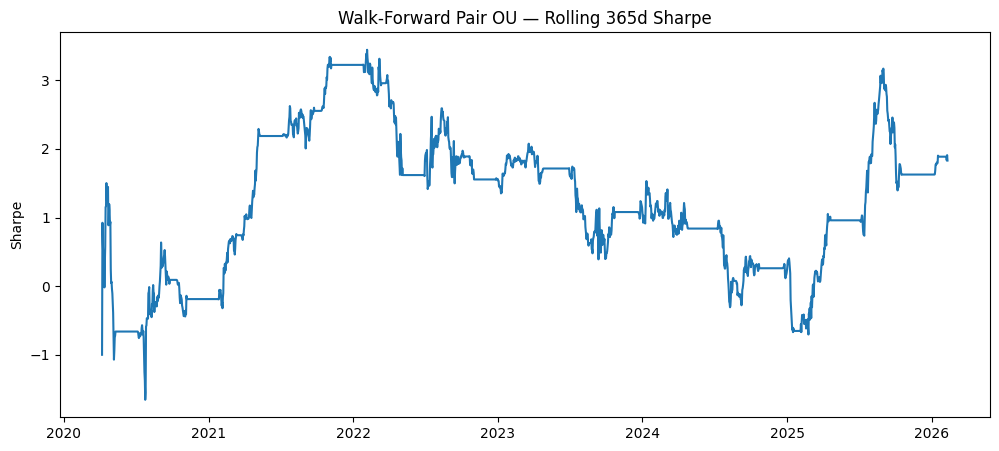

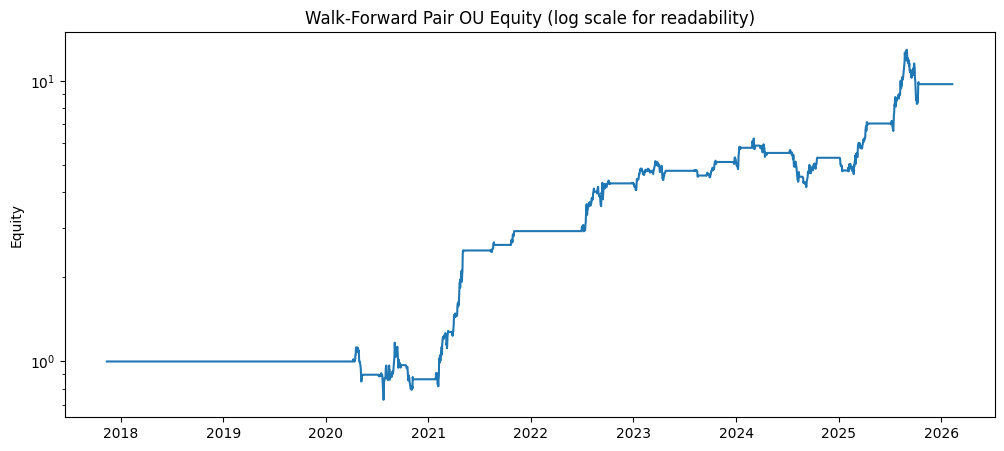

In [10]:
plt.figure(figsize=(12,5))
plt.plot(rolling_sharpe(all_test_net.fillna(0.0), window=365))
plt.title("Walk-Forward Pair OU — Rolling 365d Sharpe")
plt.ylabel("Sharpe")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(equity)
plt.yscale("log")
plt.title("Walk-Forward Pair OU Equity (log scale for readability)")
plt.ylabel("Equity")
plt.show()


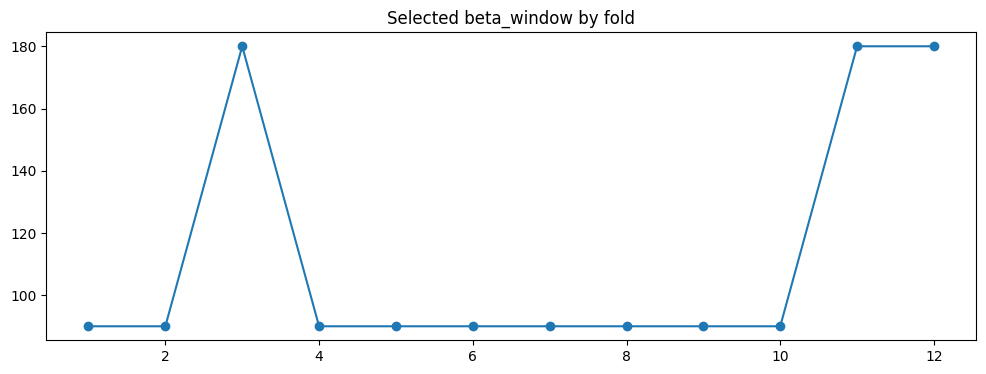

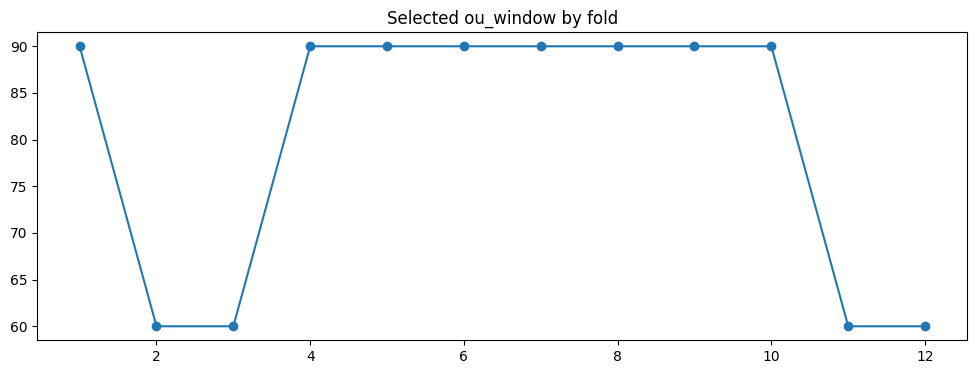

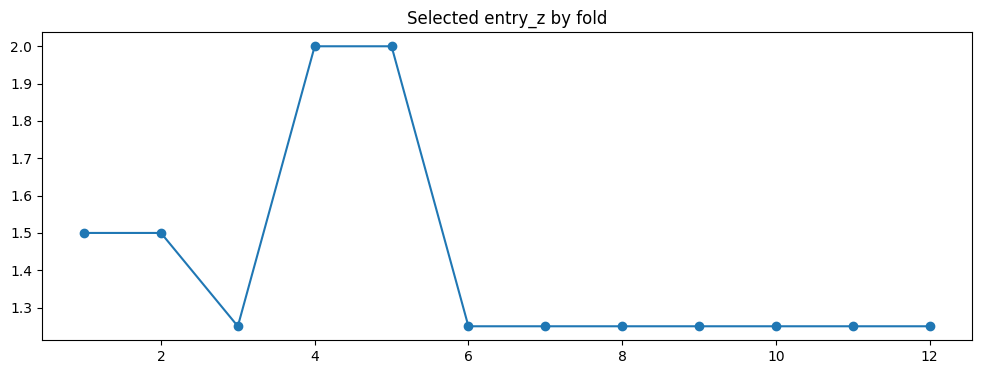

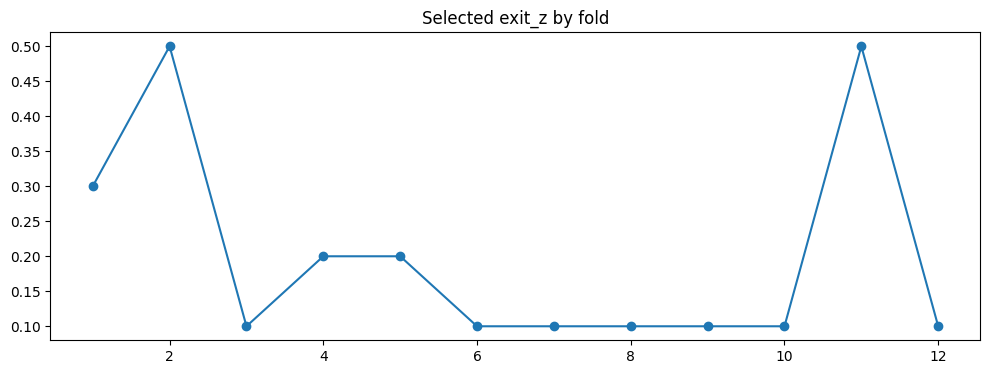

In [11]:
plt.figure(figsize=(12,4))
plt.plot(wf_table["fold"], wf_table["beta_window"], marker="o")
plt.title("Selected beta_window by fold")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(wf_table["fold"], wf_table["ou_window"], marker="o")
plt.title("Selected ou_window by fold")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(wf_table["fold"], wf_table["entry_z"], marker="o")
plt.title("Selected entry_z by fold")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(wf_table["fold"], wf_table["exit_z"], marker="o")
plt.title("Selected exit_z by fold")
plt.show()